In [1]:
import numpy as np # always need it
import scipy as sp # often use it
import pylab as pl # do the plots
import seaborn as sns # for pretty plots
import matplotlib.pyplot as plt # for pretty plots
from tqdm.notebook import tqdm as tqdm

import ot # ot 

In [2]:
def Convolution_Wasserstein(a, b, C, l):
    u = np.ones(len(a))
    K = np.exp(-C/l)
    for i in range(len(a)):
        v = b / (K.T @ u)
        u = a / (K @ v)
    T = np.diag(u) @ K @ np.diag(v)
    return T

In [27]:
def Wasserstein_barycentre(mu_i, alpha, Ht, a, ent_sharp=False, N=2):
    k = (mu_i[0].shape)
    d = np.zeros([2]+ k)
    v = np.ones([2]+ k)
    w = np.ones([2]+ k)
    for j in range(N):
        mu = np.ones(k)
        for i in range(2):
            w[i] = mu_i[i]/(Ht @ (a*v[i]))
            d[i] = v[i]*(Ht@(a*w[i]))
            mu = mu*d[i]**alpha[i]

        # entropic sharpening, optional
        if (ent_sharp):
            H_0 = H0(mu_i, a)
            mu = entropic_sharpening(mu, H_0, a)

        for i in range(2):
            v[i] = v[i]*mu/d[i]

    return mu


In [4]:
def entropic_sharpening(mu, H0, a):
    beta = 1
    if(H(mu, a) + np.transpose(a)*mu > H0 + 1 ):
        beta = sp.optimize.root(np.transpose(a)*mu**beta + H(mu**beta, a) - (1 + H0), beta > 0)
    return mu**beta

In [5]:
def H(mu, a):
    sum = 0
    for i in range(len(mu)):
        sum -= a * mu[i] * np.log(mu[i])
    return sum

In [6]:
def H0(mu_i,a):
    for i in range(len(mu_i)):
        h = H(mu_i[i],a)
        if(h > H0):
            H0 = h 
    return h

In [7]:
def Wasserstein_propagation(V, E, V0, mu_V0, Ht, a, alpha, N = 200):
    m = len(V)
    ne = len(E)
    m0,k0 = np.shape(mu_V0)
    v = np.ones((ne,k0))
    w = np.ones((k,k0))
    mu = np.ones((m,k0))
    d = np.zeros((ne,k0))
    for j in range(N):
        for i in range(m):
            if (V[i] in V0):
                mu[i] = V0(V0.index(V[i]))
                for l in range(k): #on parcourt les aretes
                    e = E[l]
                    if e[1] == V[i] :
                        w[l] = mu / Ht @ (a * v[l])
                    if e[0] == V[i] :
                        v[l] = mu / Ht @ (a * w[l])
            else:
                omega = 0
                for l in range(k):
                    e = E[l]
                    if(e[1]==V[i] or e[0]==V[i]):
                        omega += alpha[l]
                for l in range(k): #on parcourt les aretes
                    e = E[l]
                    if e[1] == V[i] :
                        d[l] = w[l] * Ht @ (a * v[l])
                    if e[0] == V[i] :
                        d[l] = v[l] * Ht @ (a * w[l])
                    mu[i] = mu[i] * d[l]**(alpha[l]/omega)
                for l in range(k): #on parcourt les aretes
                    e = E[l]
                    if e[1] == V[i] :
                        w[l] = w[l] * mu[i]/d[l]
                    if e[0] == V[i] :
                        v[l] = v[l] * mu[i]/d[l]
            

    return mu

# Exemple 1 figure 3D simple

In [9]:
class point:
    def __init__(self, x, y, z, w):
        self.x = x
        self.y = y
        self.z = z
        self.weight = w

mesh1 = np.zeros((1000), point)
alpha1 = np.zeros(1000)

for i in range(10):
    for j in range(10):
        for k in range(10):
            mesh1[i*100+j*10+k] = point(i,j,k,1)
            alpha1[i*100+j*10+k] = 1

mesh2 = np.zeros(1000, point)
alpha2 = np.zeros(1000)
r = 2.5


### Sphere
for i in range(10):
    for j in range(10):
        for k in range(10):
            if np.linalg.norm([i - 4 , j - 5,k-6]) < r :
                mesh2[i*100+j*10+k] = point(i,j,k,1)
                alpha2[i*100+j*10+k] = 1
            else : 
                mesh2[i*100+j*10+k] = point(i,j,k,0)
                alpha2[i*100+j*10+k] = 0.

### Cylindre
for i in range(10):
    for j in range(10):
        for k in range(10):
            if np.linalg.norm([i - 4 , j - 5]) < r and k < 6 :
                mesh2[i*100+j*10+k] = point(i,j,k,1)
                alpha2[i*100+j*10+k] = 1
            else : 
                mesh2[i*100+j*10+k] = point(i,j,k,0)
                alpha2[i*100+j*10+k] = 0.

alpha1 = alpha1/np.linalg.norm(alpha1)
alpha2 = alpha2/np.linalg.norm(alpha2)
# print(alpha2)

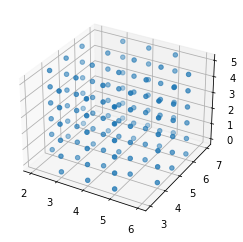

In [10]:
ax = plt.axes(projection='3d')

x = []
y = []
z = []
for k in mesh2:
    if k.weight == 1 :
        x.append(k.x)
        y.append(k.y)
        z.append(k.z)

ax.scatter3D(x, y, z, '.')


In [11]:
def kernel(n1, n2, gamma): 
    a = np.zeros((n1, n2))
    for i1 in range(n1):
        for i2 in range(n2):
            a[i1,i2] = np.exp(- np.linalg.norm([mesh1[i1].x/10 - mesh2[i2].x/10, mesh1[i1].y/10 - mesh2[i2].y/10, mesh1[i1].z/10 - mesh2[i2].z/10])**2 / 4 /gamma)
            
    return a

In [12]:
n1 = 1000
n2 = 1000
gamma = 0.1
Ht = kernel(n1, n2, gamma)
a = 1/(n1)

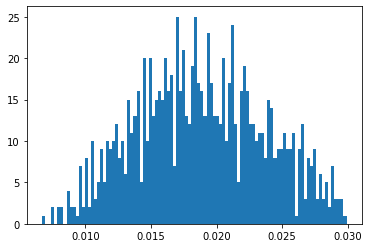

In [14]:
# print(Wasserstein_barycentre((alpha1, alpha2), (0.5, 0.5), Ht, a, N=2))
d = Wasserstein_barycentre((alpha1, alpha2), (0.5, 0.5), Ht, a, N=2)

# print(d[d>0.01])

plt.hist(d, bins=100)
plt.show()

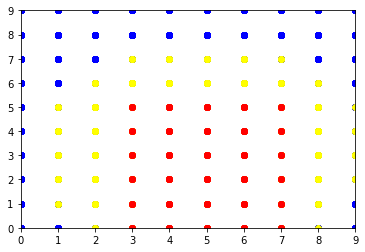

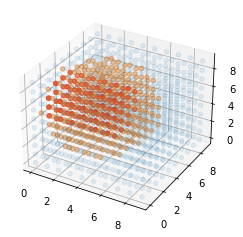

In [16]:
x = []
y = []
z = []

x1 = []
y1 = []
z1 = []

x2 = []
y2 = []
z2 = []


for i in range(len(mesh1)):
    k = mesh1[i]
    if d[i] > 0.02:
        if k.z == 5 or True:
            x.append(k.x)
            y.append(k.y)
            z.append(k.z)
    if mesh2[i].weight == 1:
        x1.append(mesh2[i].x)
        y1.append(mesh2[i].y)
        z1.append(mesh2[i].z)

    if mesh1[i].z == 5 or True: 
        x2.append(mesh1[i].x)
        y2.append(mesh1[i].y)
        z2.append(mesh1[i].z)
        
        # z.append(k.z)

plt.scatter(y2, z2, c='b')
# plt.xlim(0,9)
# plt.ylim(0,9)
# plt.show()

plt.scatter(y, z, c = 'yellow')
# plt.xlim(0,9)
# plt.ylim(0,9)
# plt.show()

plt.xlim(0,9)
plt.ylim(0,9)
plt.scatter(y1, z1, c='r')
plt.show()


ax = plt.axes(projection='3d')
ax.scatter3D(x2, y2, z2, '.', alpha=0.1)
ax.scatter3D(x, y, z, 'x', alpha = 0.4)
ax.scatter3D(z1, x1, y1, '-', c='r')


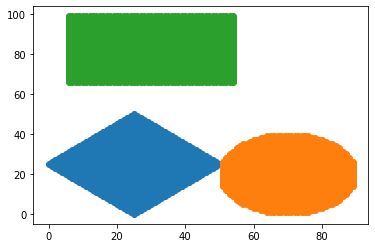

In [200]:
# 2ème exemple
class Pixel:
    def __init__(self, x, y, w):
        self.x = x
        self.y = y
        self.weight = w


objet1 = np.zeros((10000), Pixel)
alpha1 = np.zeros(10000)
x3 = []
y3 = []

for k in range(100):
    for j in range(100):
        if 0.25 * 100 * 0.5 <= j <= 0.75 * 100 * 0.5 and 0.25 * 100 *0.5<= k <= 75 *0.5:
            alpha1[k*100+j] = 1
            objet1[k*100+j] = Pixel(j, k, 1)
            x3.append(k)
            y3.append(j)
        elif k <= 25 * 0.5 and -k + 50 * 0.5 <= j <= k + 50 * 0.5:
            alpha1[k*100+j] = 1
            objet1[k*100+j] = Pixel(j, k, 1)
            x3.append(k)
            y3.append(j)
        elif k >= 75  * 0.5and k - 50  * 0.5<= j <= -k + 150 * 0.5:
            alpha1[k*100+j] = 1
            objet1[k*100+j] = Pixel(j, k, 1)
            x3.append(k)
            y3.append(j)
        elif j <= 25  * 0.5 and -j + 50 * 0.5 <= k <= j + 50 * 0.5:
            alpha1[k*100+j] = 1
            objet1[k*100+j] = Pixel(j, k, 1)
            x3.append(k)
            y3.append(j)
        elif j >= 75 * 0.5 and j - 50 * 0.5 <= k <= -j + 150 * 0.5:
            alpha1[k*100+j] = 1
            objet1[k*100+j] = Pixel(j, k, 1)
            x3.append(k)
            y3.append(j)
        else:
            alpha1[k*100+j] = 0
            objet1[k*100+j] = Pixel(j, k, 0)
plt.scatter(y3, x3)
# plt.show()

objet2 = np.zeros((10000), Pixel)
alpha2 = np.zeros(10000)
x1 = []
y1 = []
r = 20

for k in range(100):
    for j in range(100):
        if np.linalg.norm([k - 20 , j - 70]) < r:
            alpha2[k*100+j] = 1
            objet2[k*100+j] = Pixel(j,k,1)
            x1.append(k)
            y1.append(j)
        else :
            alpha2[k*100+j] = 0
            objet2[k*100+j] = Pixel(j,k,0)

objet3 = np.zeros((10000), Pixel)
alpha3 = np.zeros(10000)  
x2 = []
y2 = []          

for k in range(100):
    for j in range(100):
        if 25 < k - 40 < 75 and 25 < j +20 < 75:
            alpha3[k*100+j] = 1
            objet3[k*100+j] = Pixel(j, k, 1)
            x2.append(k)
            y2.append(j)
        else:
            alpha3[k*100+j] = 0
            objet3[k*100+j] = Pixel(j, k, 0)
plt.scatter(y1, x1)
plt.scatter(y2, x2)

plt.show()


In [237]:
def kernel(n1, n2, gamma): 
    a = np.zeros((n1, n2))
    for i1 in tqdm(range(int(n1)), total =n1):
        for i2 in range(i1):
            a[i1,i2] = np.exp(- np.linalg.norm([objet1[i1].x/100 - objet2[i2].x/100, objet1[i1].y/100 - objet2[i2].y/100])**2 /gamma)
            a[i2,i1] = a[i1,i2]
            
    return a

In [238]:
n1 = 10000
n2 = 10000
gamma = 0.1
Ht = kernel(n1, n2, gamma)
a = 1/(n1)

print(Ht)

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [61]:
Ht1 = Ht + np.identity(n1) 

0.8305690482407853


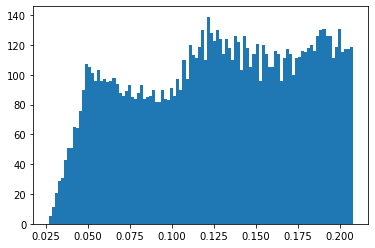

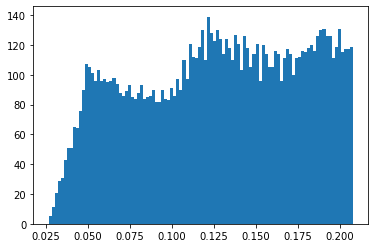

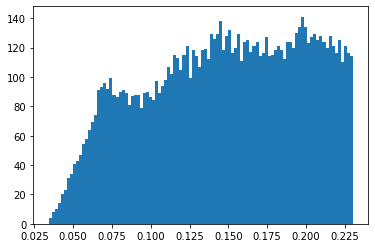

In [230]:
d1 = Wasserstein_barycentre((alpha2, alpha1), (0.5, 0.5), Ht1, a, N=2)
d2 = Wasserstein_barycentre((alpha2, alpha1), (0.5, 0.5), Ht1, a, N=10)
d3 = Wasserstein_barycentre((alpha1, alpha3), (0.5, 0.5), Ht1, a, N=10)

print(np.max(d1))

plt.hist(d1, bins=100)
plt.show()


plt.hist(d2, bins=100)
plt.show()

plt.hist(d3, bins=100)
plt.show()

m = np.median(d1)

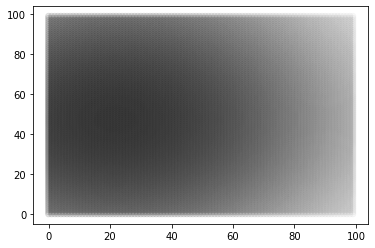

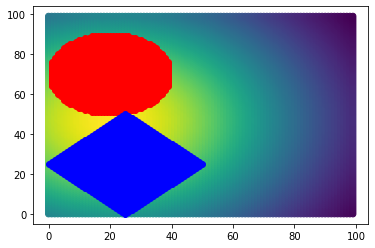

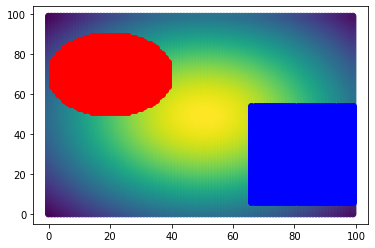

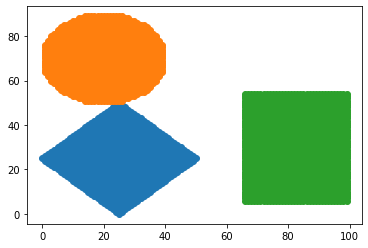

In [211]:
x = []
y = []


x1 = []
y1 = []


x2 = []
y2 = []

x3 = []
y3 = []


for i in range(len(objet1)):
    k = objet1[i]
    if d1[i] > 0.4 or True:
        if True:
            x.append(k.x)
            y.append(k.y)

    if objet2[i].weight == 1:
        x1.append(objet2[i].x)
        y1.append(objet2[i].y)

    if  objet1[i].weight == 1: 
        x2.append(objet1[i].x)
        y2.append(objet1[i].y)
    if objet3[i].weight == 1:
        x3.append(objet3[i].x)
        y3.append(objet3[i].y)
        # z.append(k.z)

# plt.xlim(0,9)
# plt.ylim(0,9)
# plt.show()


# plt.xlim(0,9)
# plt.ylim(0,9)
# plt.show()

# plt.scatter(y2, x2, c='r')



plt.scatter(y, x, c='black', alpha = 1-np.exp(-d1))
# plt.scatter(y, x, c = d1)




plt.show()
plt.scatter(y, x, c = d2)
plt.scatter(y1, x1, c='r')
plt.scatter(y2, x2, c='b')
plt.show()


plt.scatter(y, x, c = d3)
plt.scatter(y1, x1, c='r')
plt.scatter(y3, x3, c='b')
plt.show()


plt.scatter(y2, x2)
plt.scatter(y1, x1)
plt.scatter(y3, x3)

# ax = plt.axes(projection='3d')
# ax.scatter3D(x2, y2, z2, '.', alpha=0.1)
# ax.scatter3D(x, y, z, 'x', alpha = 0.4)
# ax.scatter3D(z1, x1, y1, '-', c='r')

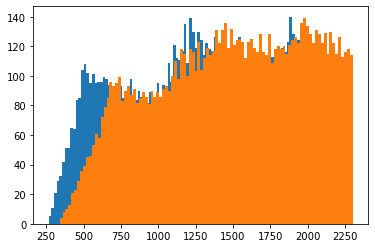

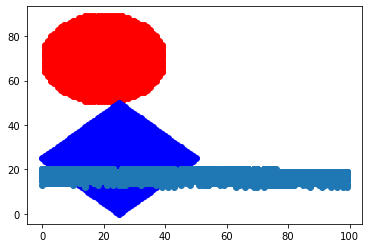

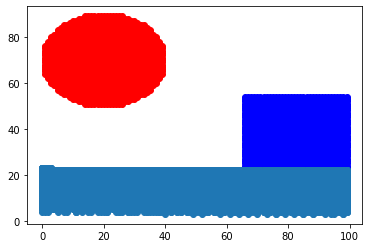

In [250]:
d1.shape[0]


d_test = (d3 * 10000).astype(int)
d_test2 = (d2 * 10000).astype(int)
x = []
y = []

plt.hist(d_test2, bins=100)
plt.hist(d_test, bins=100)
plt.show()

for j in range(10000):
    if (objet2[j].weight == 1) or (objet1[j].weight == 1):
        x.append(objet2[d_test2[j]].x)
        y.append(objet2[d_test2[j]].y)
    # x.append(j % 100)
    # y.append(j // 100)


plt.scatter(y1, x1, c='r')
plt.scatter(y2, x2, c='b')

plt.scatter(x, y)
plt.show()

x = []
y = []

for j in d_test:
    x.append(objet1[j].x)
    y.append(objet1[j].y)

plt.scatter(y1, x1, c='r')
plt.scatter(y3, x3, c='b')

plt.scatter(x, y)


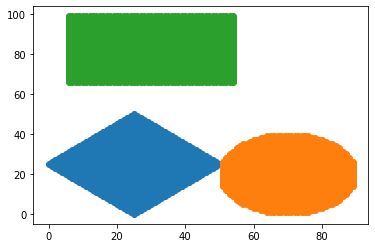

In [12]:
# 2ème exemple
class Pixel:
    def __init__(self, x, y, w):
        self.x = x
        self.y = y
        self.weight = w

image1 = np.zeros((100,100))
objet1 = np.zeros((10000), Pixel)
alpha1 = np.zeros(10000)
x3 = []
y3 = []

for k in range(100):
    for j in range(100):
        if 0.25 * 100 * 0.5 <= j <= 0.75 * 100 * 0.5 and 0.25 * 100 *0.5<= k <= 75 *0.5:
            alpha1[k*100+j] = 1
            objet1[k*100+j] = Pixel(j, k, 1)
            image1[k,j] = 1
            x3.append(k)
            y3.append(j)
        elif k <= 25 * 0.5 and -k + 50 * 0.5 <= j <= k + 50 * 0.5:
            alpha1[k*100+j] = 1
            objet1[k*100+j] = Pixel(j, k, 1)
            image1[k,j] = 1
            x3.append(k)
            y3.append(j)
        elif k >= 75  * 0.5and k - 50  * 0.5<= j <= -k + 150 * 0.5:
            alpha1[k*100+j] = 1
            objet1[k*100+j] = Pixel(j, k, 1)
            image1[k,j] = 1
            x3.append(k)
            y3.append(j)
        elif j <= 25  * 0.5 and -j + 50 * 0.5 <= k <= j + 50 * 0.5:
            alpha1[k*100+j] = 1
            objet1[k*100+j] = Pixel(j, k, 1)
            image1[k,j] = 1
            x3.append(k)
            y3.append(j)
        elif j >= 75 * 0.5 and j - 50 * 0.5 <= k <= -j + 150 * 0.5:
            alpha1[k*100+j] = 1
            objet1[k*100+j] = Pixel(j, k, 1)
            image1[k,j] = 1
            x3.append(k)
            y3.append(j)
        else:
            alpha1[k*100+j] = 0
            objet1[k*100+j] = Pixel(j, k, 0)
plt.scatter(y3, x3)
# plt.show()

objet2 = np.zeros((10000), Pixel)
alpha2 = np.zeros(10000)
image2 = np.zeros((100,100))
x1 = []
y1 = []
r = 20

for k in range(100):
    for j in range(100):
        if np.linalg.norm([k - 20 , j - 70]) < r:
            alpha2[k*100+j] = 1
            objet2[k*100+j] = Pixel(j,k,1)
            image2[k,j] = 1
            x1.append(k)
            y1.append(j)
        else :
            alpha2[k*100+j] = 0
            objet2[k*100+j] = Pixel(j,k,0)


objet3 = np.zeros((10000), Pixel)
alpha3 = np.zeros(10000)  
image3 = np.zeros((100,100))
x2 = []
y2 = []          

for k in range(100):
    for j in range(100):
        if 25 < k - 40 < 75 and 25 < j +20 < 75:
            alpha3[k*100+j] = 1
            objet3[k*100+j] = Pixel(j, k, 1)
            image3[k,j] = 1
            x2.append(k)
            y2.append(j)
        else:
            alpha3[k*100+j] = 0
            objet3[k*100+j] = Pixel(j, k, 0)
plt.scatter(y1, x1)
plt.scatter(y2, x2)

plt.show()


In [13]:
image1 = image1/np.sum(image1)
image2 = image2/np.sum(image2)
image3 = image3/np.sum(image3)


In [16]:
def kern_img(n1,n2, gamma):
    H = np.zeros((100,100,100,100))
    for i in tqdm(range(100), total=100):
        for j in range(100):
            for k in range(100):
                for l in range(100):
                    H[i,j,k,l] = np.exp(-1 / gamma * np.linalg.norm([(i - k)/200, (j - l)/200])**2)
    return H

In [20]:
Ht = kern_img(100,100,0.01)
a = 1

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [28]:
d1 = Wasserstein_barycentre((objet1, objet2), (0.5, 0.5), Ht, 1, N=2)
# d2 = Wasserstein_barycentre((alpha2, alpha1), (0.5, 0.5), Ht1, a, N=10)
# d3 = Wasserstein_barycentre((alpha1, alpha3), (0.5, 0.5), Ht1, a, N=10)

plt.hist(d1, bins=100)

TypeError: can only concatenate list (not "tuple") to list

In [24]:
[1]+ [1,2]

[1, 1, 2]